<a href="https://colab.research.google.com/github/marianaketleyfer/Emerging-AI-Technologies-and-Sustainability/blob/main/Final_Sentiment_Analysis__VADER%2C_RoBERTa_and_DistilBERT_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Learning Strategies for Next-Gen Sentiment Analysis with Green AI Practices

---
"We find that training a single deep learning model can emit as much carbon as five cars in their lifetimes" (Strubell, Ganesh, & McCallum, 2019).

This notebook explores sentiment analysis on the Amazon Fine Food Reviews dataset, focusing on consumer attitudes towards green products. The study follows the CRISP-DM methodology and applies advanced deep learning techniques, including VADER for rule-based analysis and RoBERTa for fine-tuned transformer-based modeling. It incorporates TF-IDF vectorization and Logistic Regression, optimized through Hyperparameter GridSearchCV. To enhance efficiency and align with Green AI practices, the DistilBERT Tokenizer and Model Pruning are utilized, reducing memory usage and environmental impact. Performance is evaluated using precision, recall, and F1-score, providing valuable insights for businesses to develop sustainable strategies.

Step-by-step:

*   Load Dataset
*   Data Cleaning
*   Data Preprocessing
*   Identify Green Products
*   Preliminary Sentiment Analysis (VADER)
*   Modelling: RoBERTa model
*   Comparative Vader x RoBERTa x DistillBERT and Pruning Model
*   Green AI Practices
*   Training & Test
*   Evaluate Models

Dataset: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

# Initialization

## Loading all necessary imports

In [ ]:
!pip install datasets wordcloud pandarallel memory_profiler

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from operator import itemgetter
from tqdm.notebook import tqdm
from pandarallel import pandarallel

tqdm.pandas()
pandarallel.initialize(progress_bar=True)
plt.style.use('ggplot')

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Mounting Google drive to load remote .csv file locally

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading remote .csv into DataFrame

In [ ]:
df = pd.read_csv(
    '/content/drive/MyDrive/Reviews.csv',
    dtype={'Id': 'int64', 'HelpfulnessNumerator': 'int64', 'HelpfulnessDenominator': 'int64', 'Score': 'int64'})

### Displaying first 5 records

In [ ]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

### Displaying the DataFrame's Columns info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# Formatting the Data

## Defining custom methods for data formatting

### Creating a dictionary for common abbreviations

In [ ]:
chat_words_map_dict = {}
chat_words_list = []

chat_words_str = """
BRB: Be Right Back (often used when someone is going to get food)
BBQ: Barbecue
BF: Breakfast
BR: Brunch
DIN: Dinner
LUN: Lunch
MSG: Monosodium Glutamate (a flavor enhancer often mentioned in food contexts)
PPL: People (often used in the context of dining out with friends or a group)
PLS: Please (often used when ordering food)
YUM: Something tasty or delicious
GR8: Great (often used to describe a meal)
NP: No Problem (often used in the context of service or food requests)
OMW: On My Way (often used when heading to a restaurant)
K: OK (often used in food ordering and confirmations)
TY: Thank You (often used in the context of receiving food or service)
YW: You're Welcome (often used in the context of providing food or service)
CU: See You (often used when planning to meet at a restaurant)
FYI: For Your Information (often used to share food-related information)
HMU: Hit Me Up (often used to suggest going out for a meal)
ICYMI: In Case You Missed It (often used to share food-related news or deals)
IMO: In My Opinion (often used to share opinions about food or restaurants)
SUP: What's Up (often used to ask about dining plans)
F2T: Farm to Table (a movement promoting local food production)
GF: Gluten-Free
OR: Organic
V: Vegetarian
VGN: Vegan
NONGMO: Non-Genetically Modified Organism (indicating food products not containing GMOs)
CSA: Community Supported Agriculture (a system connecting producers and consumers)
EPA: Environmental Protection Agency (often involved in regulating agrotoxins)
FDA: Food and Drug Administration (regulating food safety)
FSA: Food Standards Agency (regulating food safety in some countries)
IFOAM: International Federation of Organic Agriculture Movements (promotes organic farming)
NOP: National Organic Program (regulates organic farming in the US)
PES: Pesticides (substances used for destroying insects or other organisms harmful to plants or animals)
RTB: Ready To Bake (food products ready for baking)
RTC: Ready To Cook (food products ready for cooking)
RTE: Ready To Eat (food products ready for consumption without further preparation)
CSA: Community Supported Agriculture (a system connecting producers and consumers to support local farming)
LOC: Locally Grown (food produced within a short distance of where it is consumed)
SFM: Sustainable Food Movement (promotes sustainable food practices)
PB: Plant-Based
WPB: Whole Plant-Based (diet emphasizing whole, unprocessed plant foods)
RAW: Raw Food (diet consisting mainly of uncooked, unprocessed foods)
NT: Nutritarian (diet focusing on nutrient-dense foods, often plant-based)
HCLF: High Carb Low Fat (diet focusing on high carbohydrate, low fat intake, often plant-based)
LCHF: Low Carb High Fat (diet focusing on low carbohydrate, high fat intake)
TF: Tofu (a common plant-based protein made from soybeans)
TVP: Textured Vegetable Protein (a plant-based protein often used in meat substitutes)
WW: Whole Wheat (used to indicate whole wheat products, often in bread and pasta)
FF: Fresh Food (emphasizing fresh, non-processed ingredients)
B12: Vitamin B12 (often mentioned in the context of vegan diets for supplementation)
OMEGA3: Omega-3 Fatty Acids (important for plant-based diets, often derived from flaxseeds, chia seeds, and algae)
"""

for line in chat_words_str.split("\n"):
    if line != "":
        cw, cw_expanded = line.split(":")
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded.strip()

## Converting text to lowercase

In [ ]:
df["text_lower"] = df["Text"].str.lower()
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

                                          text_lower  
0  i have bought several of the vitality canned d...  
1  product arrived labeled as jumbo salted peanut...  
2  this is a confection that has been around a fe...  
3  if you are looking for the secret ingredient i...  
4  great taffy at a great price.  there was a wid...

## Converting emoticons and emojis from lowercase text

In [ ]:
def convert_emoticons_and_emojis(text):
    import re

    EMOTICONS = {
        ":-)": "happy",
        ":)": "happy",
        ":-(": "sad",
        ":(": "sad",
        ":D": "laugh",
        ":‑)": "laugh",
        ":)": "laugh",
        ">:(": "sad",
        "DX": "sad",
        "XD": "laugh",
        "xD": "laugh",
        "X-D": "laugh",
        "D:<": "disgust",
        ";‑)": "wink",
        ";)": "wink",
        ";‑D": "wink",
        ";D": "wink",
        ";‑)": "wink",
        ";)": "wink",
        ">:‑)": "evil",
        ">:D": "evil",
        ":-/": "confused",
        ":/": "confused",
        ":‑P": "playful",
        ":P": "playful",
        "X‑P": "playful",
        "XP": "playful",
        ":‑p": "playful",
        ":p": "playful",
        "X‑p": "playful",
        "xp": "playful",
        "X_X": "dead person",
        "<3": "love",
        "x3": "love",
        "＼(^o^)／": "excited",
        "D:": "excited",
        "D8": "excited",
        "D;": "excited",
        "D=": "excited",
        "8‑D": "excited",
        "8D": "excited",
        "x‑D": "excited",
        "xD": "excited",
        "X‑D": "excited",
        "XD": "excited",
        "=-D": "excited",
    }

    UNICODE_EMO = {
        "😋": "delicious",
        "😂": "laugh",
        "🤣": "laugh",
        "😍": "amazing",
        "😊": "happy",
        "😇": "happy",
        "🥰": "love",
        "😎": "cool",
        "🤩": "love",
        "🥳": "party",
        "🤪": "laugh",
        "😝": "sad",
        "😞": "sad",
        "😟": "sad",
        "😕": "confused",
        "🙁": "sad",
        "☹": "sad",
        "😣": "sad",
        "😖": "sad",
        "😫": "sad",
        "😩": "sad",
        "🥺": "sad",
        "😢": "sad",
        "😭": "sad",
        "😤": "angry",
        "😡": "angry",
        "😠": "angry",
        "🤬": "angry",
        "🤯": "mind",
        "😳": "disgust",
        "🥵": "disgust",
        "🥶": "disgust",
        "😱": "disgust",
        "😨": "disgust",
        "😰": "disgust",
        "😥": "sad",
        "😓": "sad",
        "🤗": "hug",
        "🤔": "confused",
        "🤭": "confused",
        "🤫": "confused",
        "🤥": "sad",
        "😶": "neutral",
        "😐": "neutral",
        "😑": "neutral",
        "😯": "happy",
        "😦": "sad",
        "😧": "sad",
        "😨": "sad",
        "😰": "sad",
        "😥": "sad",
        "😓": "sad",
        "🤗": "hug",
        "🤔": "confused",
        "🤭": "confused",
        "🤫": "confused",
        "🤥": "sad",
        "😶": "neutral",
        "😐": "neutral",
        "😑": "neutral",
        "😯": "happy",
        "😦": "sad",
        "😧": "sad",
        "😨": "sad",
        "😰": "sad",
        "😥": "sad",
        "😓": "sad",
        "🤗": "hug",
        "🤔": "confused",
        "🤭": "confused",
        "🤫": "confused",
        "🤥": "sad",
        "😶": "neutral",
        "😐": "neutral",
        "😑": "neutral",
        "😯": "happy",
        "😦": "sad",
        "😧": "sad",
        "😜": "Cool",
        "😝": "Cool",
        "🤪": "Crazy",
        "🤑": "Expansive",
        "🤑🤑": "Very Expansive",
        "🤑🤑🤑": "Extremely Expansive",
        "🤑🤑🤑🤑": "Extremely Expansive",
        "☹️": "frown",
        "😢": "sad",
        "😖": "frow",
        "🥹": "cute",
        "😮": "surprised",
        "😯": "surprise",
        "😲": "surprise",
        "😳": "disgust",
        "😍": "kiss",
        "😘": "kiss",
        "😘😘": "kiss",
        "😘😘😘": "kiss and love",
        "😏": "Tongue-in-cheek",
        "🤢": "being sick",
        "☠️": "dead",
        "❤️": "love",
        "👍": "thumbs up",
        "👎": "thumbs down",
        "🍻": "cheer's",
        "😵": "fainted",
        "🤨": "disapproval",
        "🧐": "disapproval",
        "😥": "sweat drop",
        "🙌": "joyful",
        "🙏": "thankful",
        "🤭": "Giggling",
        "🤫": "Shushing",
        "😀": "excited",
        "💃": "excited",
        "🕺": "excited",
        "🤙": "excited",
        "🔥": "spicy",
    }

    def convert_emojis(text):
        for emot in UNICODE_EMO:
            text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
        return text

    def convert_emoticons(text):
        for emot in EMOTICONS:
            text = re.sub(u'(' + re.escape(emot) + ')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        return text

    return convert_emoticons(convert_emojis(text))

df["text_lower"] = df["text_lower"].parallel_apply(convert_emoticons_and_emojis)
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

                                          text_lower  
0  i have bought several of the vitality canned d...  
1  product arrived labeled as jumbo salted peanut...  
2  this is a confection that has been around a fe...  
3  if you are looking for the secret ingredient i...  
4  great taffy at a great price.  there was a wid...

## Lemmatize all text


In [ ]:
nltk.download('wordnet')

def lemmatize_words(text):
    from nltk.stem import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text_lemmatized"] = df["text_lower"].parallel_apply(lemmatize_words)
df = df.drop(columns=["text_lower"])
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

                                     text_lemmatized  
0  i have bought several of the vitality canned d...  
1  product arrived labeled a jumbo salted peanuts...  
2  this is a confection that ha been around a few...  
3  if you are looking for the secret ingredient i...  
4  great taffy at a great price. there wa a wide ...

## Remove stopwords from lemmatized text

In [ ]:
nltk.download('stopwords')

def remove_stopwords(text):
    import nltk

    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_lemmatized"].parallel_apply(remove_stopwords)
df = df.drop(columns=["text_lemmatized"])
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

                                        text_wo_stop  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanuts.....  
2  confection ha around centuries. light, pillowy...  
3  looking secret ingredient robitussin believe f...  
4  great taffy great price. wa wide assortment yu...

## Identify Green Products

In [ ]:
def is_green_product(description):
    green_keywords = [
        'organic', 'eco-friendly', 'biodegradable', 'sustainable', 'green', 'natural', 'environmentally friendly',
        'non-GMO', 'fair trade', 'locally sourced', 'farm-to-table', 'pesticide-free', 'hormone-free', 'grass-fed',
        'free-range', 'cage-free', 'certified humane', 'biodynamic', 'carbon-neutral', 'compostable', 'cruelty-free',
        'renewable', 'recyclable packaging', 'low carbon footprint', 'ethical', 'vegan', 'plant-based', 'gluten-free',
        'preservative-free', 'chemical-free', 'sustainable farming', 'fresh', 'sustainable packaging', 'organic ingredients',
        'chemical-free', 'eco-conscious', 'ethical sourcing', 'zero waste', 'renewable energy', 'minimal processing',
        'non-toxic', 'fresh', 'eco-packaging', 'low-impact', 'responsibly sourced', 'upcycled ingredients', 'no additives',
        'locally grown', 'naturally raised', 'clean eating', 'eco-certified', 'earth-friendly', 'green certified',
        'nutrient-dense', 'solar-powered', 'green farming', 'regenerative agriculture', 'hydroponic', 'organic certified',
        'small-batch', 'wildlife-friendly', 'low-emission', 'handcrafted', 'artisanal', 'holistic', 'grassroots',
        'ethical farming', 'pure', 'non-polluting', 'naturally flavored', 'heirloom varieties', 'sustainable seafood',
        'organic', 'eco-friendly', 'biodegradable', 'sustainable', 'green', 'natural', 'environmentally friendly',
        'non-GMO', 'fair trade', 'locally sourced', 'farm-to-table', 'pesticide-free', 'hormone-free', 'grass-fed',
        'free-range', 'cage-free', 'certified humane', 'biodynamic', 'carbon-neutral', 'compostable', 'cruelty-free',
        'renewable', 'recyclable packaging', 'low carbon footprint', 'ethical', 'vegan', 'plant-based', 'gluten-free',
        'preservative-free', 'chemical-free', 'sustainable farming', 'fresh', 'sustainable packaging', 'organic ingredients',
        'chemical-free', 'eco-conscious', 'ethical sourcing', 'zero waste', 'renewable energy', 'minimal processing',
        'non-toxic', 'eco-packaging', 'low-impact', 'responsibly sourced', 'upcycled ingredients', 'no additives',
        'locally grown', 'naturally raised', 'clean eating', 'eco-certified', 'earth-friendly', 'green certified',
        'nutrient-dense', 'solar-powered', 'green farming', 'regenerative agriculture', 'hydroponic', 'organic certified',
        'small-batch', 'wildlife-friendly', 'low-emission', 'handcrafted', 'artisanal', 'holistic', 'grassroots',
        'ethical farming', 'pure', 'non-polluting', 'naturally flavored', 'heirloom varieties', 'sustainable seafood'
    ]

    return any(keyword in description.lower() for keyword in green_keywords)

df['is_green'] = df['text_wo_stop'].parallel_apply(is_green_product)

## Formatted DataFrame info

### Displaying first 5 records

In [ ]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

                                        text_wo_stop  is_green  
0  bought several vitality canned dog food produc...     False  
1  product arrived labeled jumbo salted peanuts.....     False  
2  confection ha around centuries. light, pillowy...     False  
3  looking secret ingredient robitussin believe f...     False  
4  great taffy great price. wa wide assortment yu...     False

### Green vs Non-Green Count

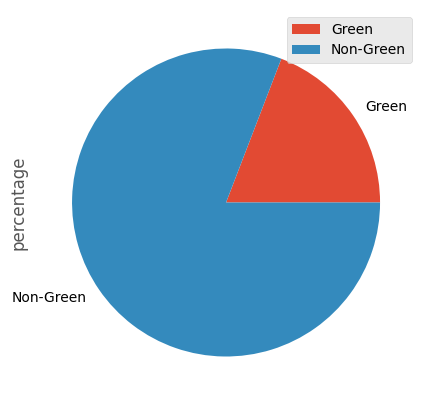

In [ ]:
total = len(df)
green = len(df[df['is_green']])
non_green = total - green

df_stats = pd.DataFrame({'percentage': [(100*green)/total, (100*non_green)/total]}, index=['Green', 'Non-Green'])
plot = df_stats.plot.pie(y='percentage', figsize=(5, 5))

### WordCloud - Sentiment Analysis

#### Green Items

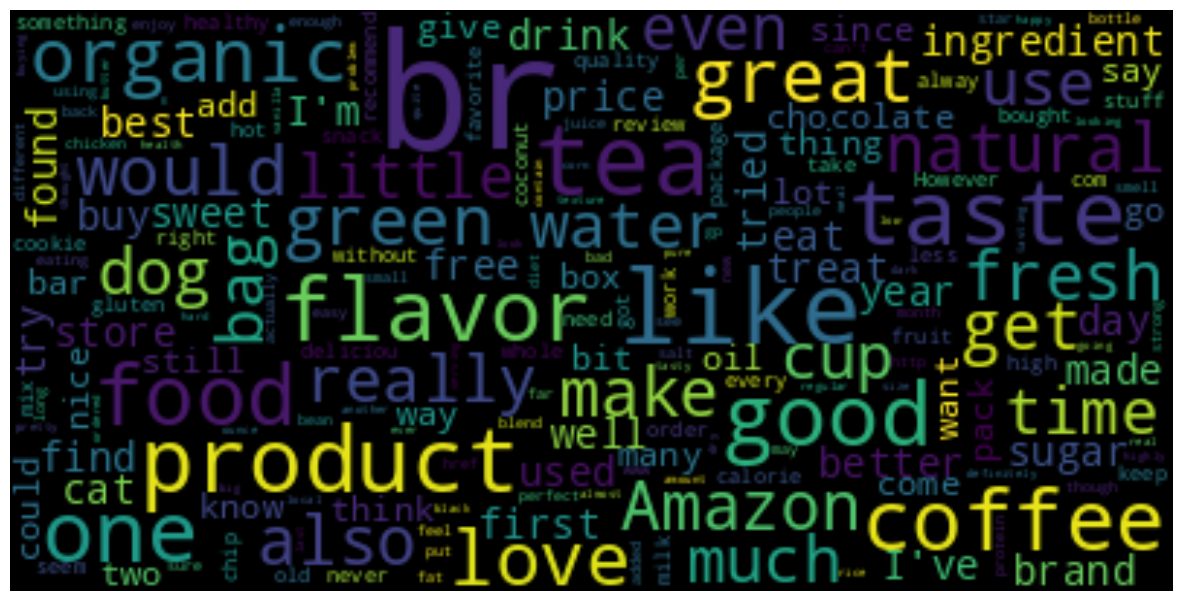

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

nltk.download('stopwords')

wc = WordCloud(collocations=False, stopwords=set(stopwords.words('english')), max_font_size=55, background_color="black")
wc.generate(' '.join(df[df['is_green']]['Text']))
plt.figure(figsize=(15,26))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

#### Non-Green Items

(-0.5, 399.5, 199.5, -0.5)

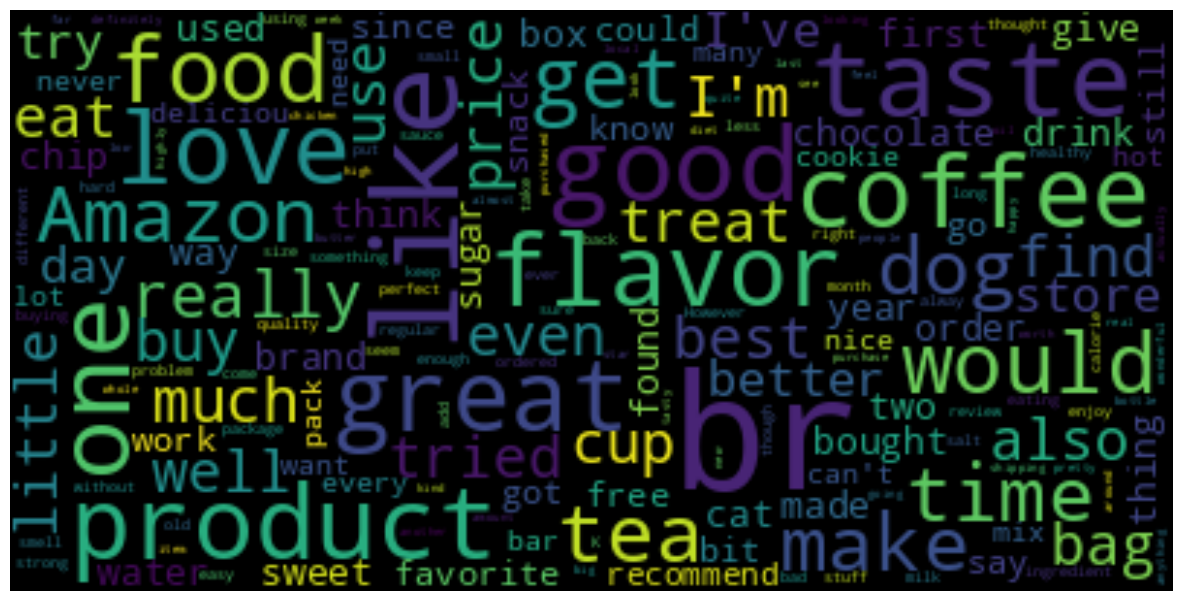

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

nltk.download('stopwords')

wc = WordCloud(collocations=False, stopwords=set(stopwords.words('english')), max_font_size=55, background_color="black")
wc.generate(' '.join(df[~df['is_green']]['Text']))
plt.figure(figsize=(15,26))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

# Sentiment Analysis

## VADER

### Calculating Polarity Scores

In [ ]:
%load_ext memory_profiler

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('vader_lexicon')

def get_polarity_scores(row):
    from operator import itemgetter
    from nltk.sentiment import SentimentIntensityAnalyzer

    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(row['text_wo_stop'])
    row['neg'], row['neu'], row['pos'], row['compound'] = itemgetter('neg', 'neu', 'pos', 'compound')(scores)
    return row

%memit df = df.parallel_apply(get_polarity_scores, axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


peak memory: 2768.16 MiB, increment: 750.43 MiB



### Plotting VADER results


#### Compound Score by Amazon Star Review

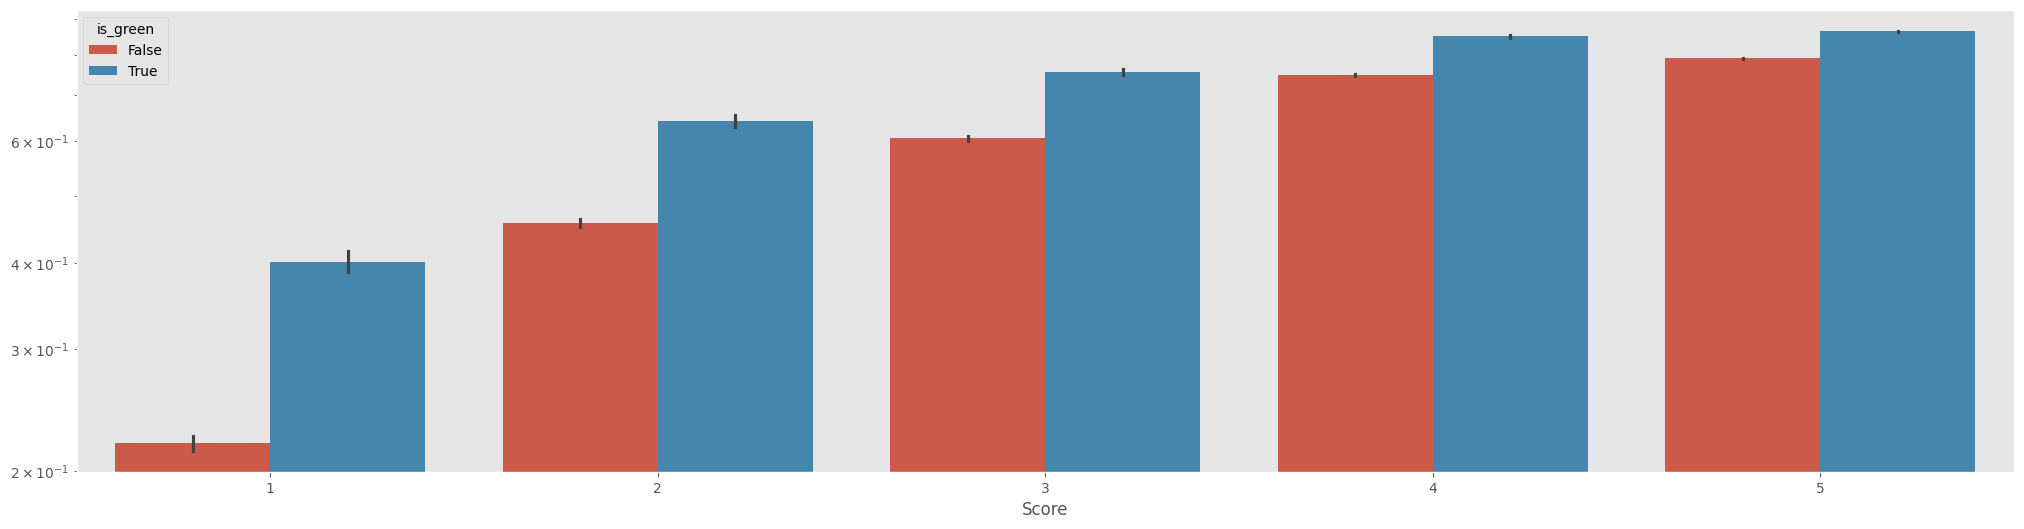

In [ ]:
plt.figure(figsize=(25, 6))
sns.barplot(data=df, x='Score', y='compound', hue="is_green").set(ylabel=None, yscale="log")
plt.show()

#### Polarity Comparative

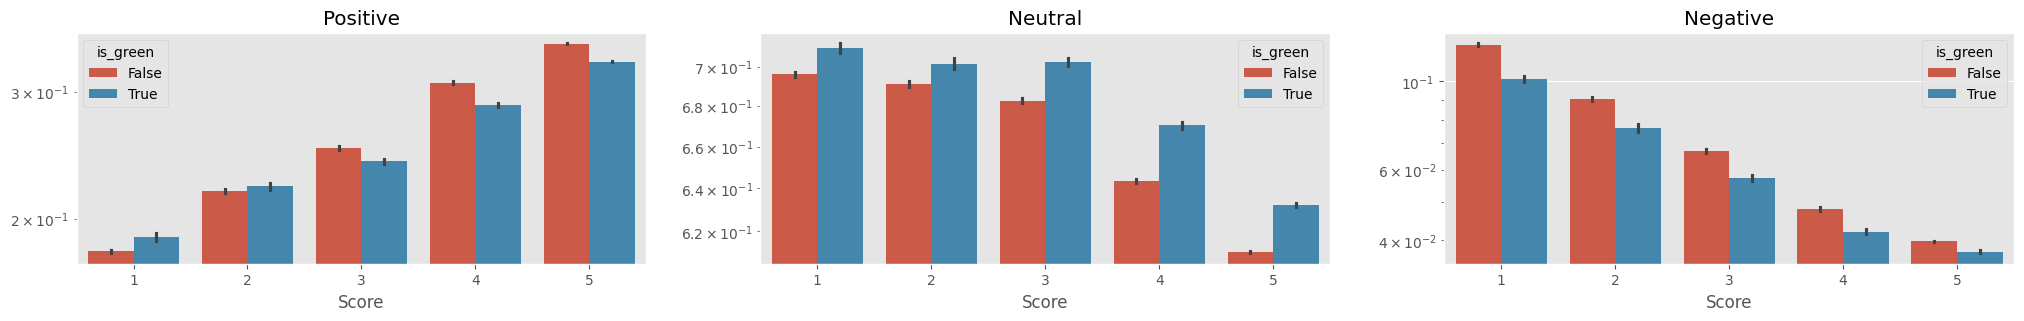

In [ ]:
_, axs1 = plt.subplots(1, 3, figsize=(25, 3))

for index, field, title in [(0, 'pos', 'Positive'), (1, 'neu', 'Neutral'), (2, 'neg', 'Negative')]:
  sns.barplot(data=df, x='Score', y=field, hue="is_green", ax=axs1[index]).set(ylabel=None, yscale="log")
  axs1[index].set_title(title)

plt.show()

## Roberta

### Calculating Polarity Scores

In [ ]:
%load_ext memory_profiler
import torch
from scipy.special import softmax

from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

@torch.autocast(device_type="cuda")
def get_polarity_scores_roberta(row):
    try:
      encoded_text = tokenizer(row['Text'], return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
      output = model(**encoded_text)

      scores = output.logits[0].cpu().detach().numpy()
      probabilities = softmax(scores)

      row['rob_neg'], row['rob_neu'], row['rob_pos'] = probabilities
    except RuntimeError as e:
      print(f'Broke for id {row["Id"]} - {e}')
    return row

%memit df = df.progress_apply(get_polarity_scores_roberta, axis=1)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/568454 [00:00<?, ?it/s]

peak memory: 7761.71 MiB, increment: 3095.73 MiB


### Plotting Roberta results

#### Polarity Comparative

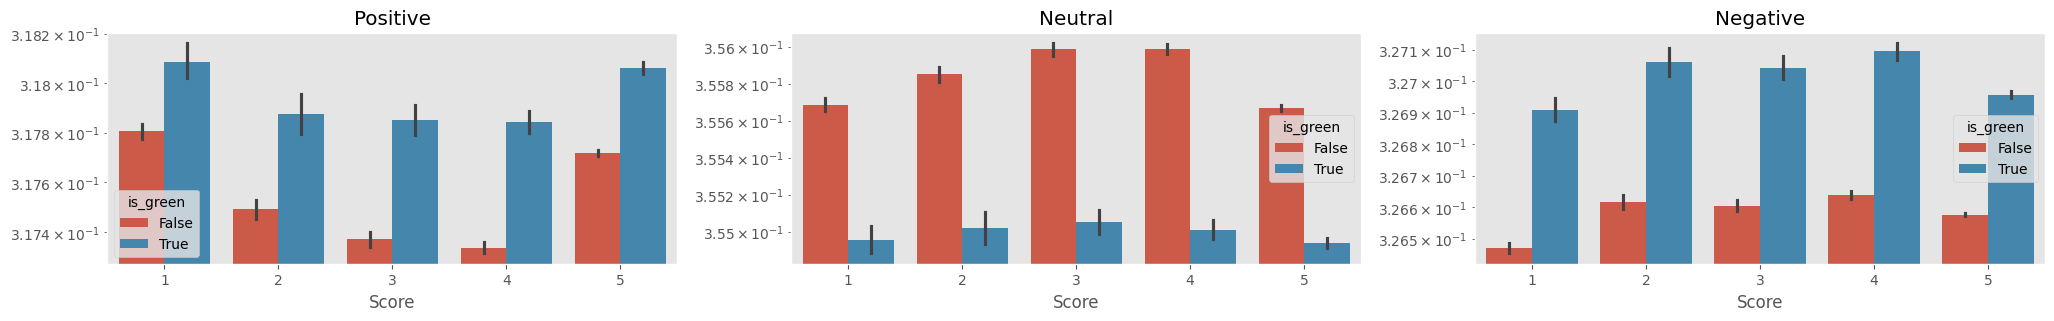

In [ ]:
_, axs1 = plt.subplots(1, 3, figsize=(25, 3))

for index, field, title in [(0, 'rob_pos', 'Positive'), (1, 'rob_neu', 'Neutral'), (2, 'rob_neg', 'Negative')]:
  sns.barplot(data=df, x='Score', y=field, hue="is_green", ax=axs1[index]).set(ylabel=None, yscale="log")
  axs1[index].set_title(title)

plt.show()

## Green - AI Practices (DistilBERT tokenizer and Pruning Model)

In [ ]:
%load_ext memory_profiler

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn.utils import prune
from scipy.special import softmax

# Preprocess data
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

# Selecting relevant columns
X = df['Text']
y = df['Sentiment']

# Initialize DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define a function to apply pruning to the model
def prune_model(model):
    # Apply pruning to the linear layers
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.random_unstructured(module, name='weight', amount=0.2)  # Prune 20% of weights

prune_model(model)  # Apply pruning to the model

# Define function to get polarity scores using DistilBERT
@torch.autocast(device_type="cuda")
def get_polarity_scores_distilbert(row):
    try:
        # Extract pre-tokenized input
        encoded_input = tokenizer(row['text_wo_stop'], max_length=512, padding='max_length', truncation=True, return_tensors='pt')

        # Move inputs to the device
        input_ids = encoded_input['input_ids'].to(device)  # Access input_ids from encoded_input
        attention_mask = encoded_input['attention_mask'].to(device)  # Access attention_mask from encoded_input

        # Forward pass through the model with mixed precision
        output = model(input_ids=input_ids, attention_mask=attention_mask)

        # Compute the softmax probabilities
        scores = output.logits[0].cpu().detach().numpy()
        probabilities = softmax(scores)

        # Update the row with the computed probabilities
        row['distil_neg'], row['distil_neu'], row['distil_pos'] = probabilities
    except RuntimeError as e:
        print(f'Error processing id {row["Id"]} - {e}')
    return row

# Apply the function to the dataframe
%memit df = df.progress_apply(lambda x: get_polarity_scores_distilbert(x), axis=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/568454 [00:00<?, ?it/s]

peak memory: 3432.12 MiB, increment: 1824.98 MiB


### Plotting DistilBERT results

#### Polarity Comparative

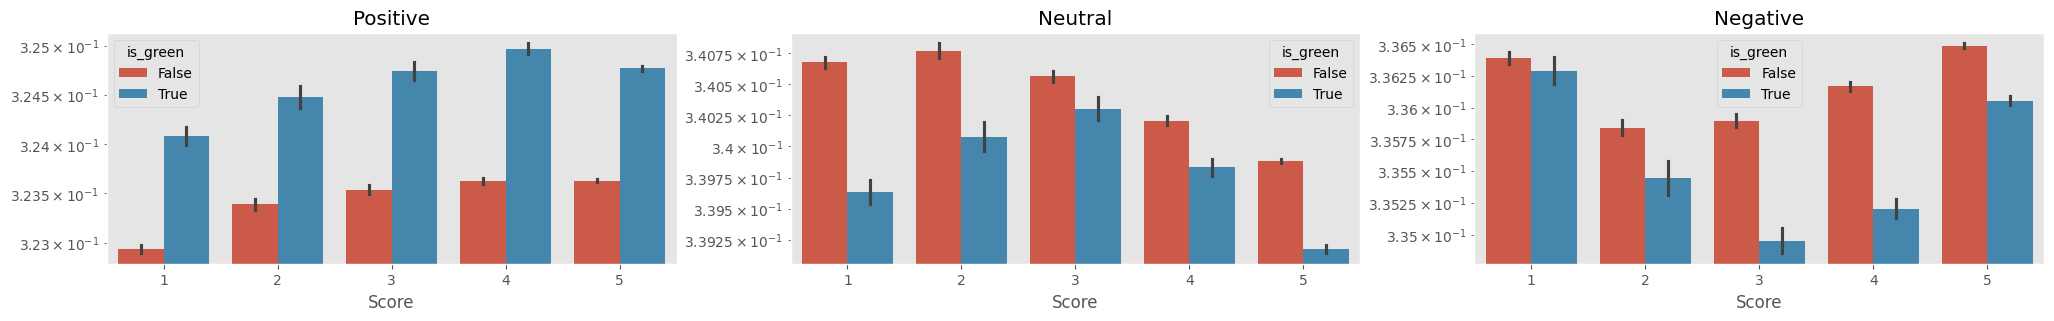

In [ ]:
_, axs1 = plt.subplots(1, 3, figsize=(25, 3))

for index, field, title in [(0, 'distil_pos', 'Positive'), (1, 'distil_neu', 'Neutral'), (2, 'distil_neg', 'Negative')]:
  sns.barplot(data=df, x='Score', y=field, hue="is_green", ax=axs1[index]).set(ylabel=None, yscale="log")
  axs1[index].set_title(title)

plt.show()

## Vader x Roberta x DistilBERT Polarity Comparitive

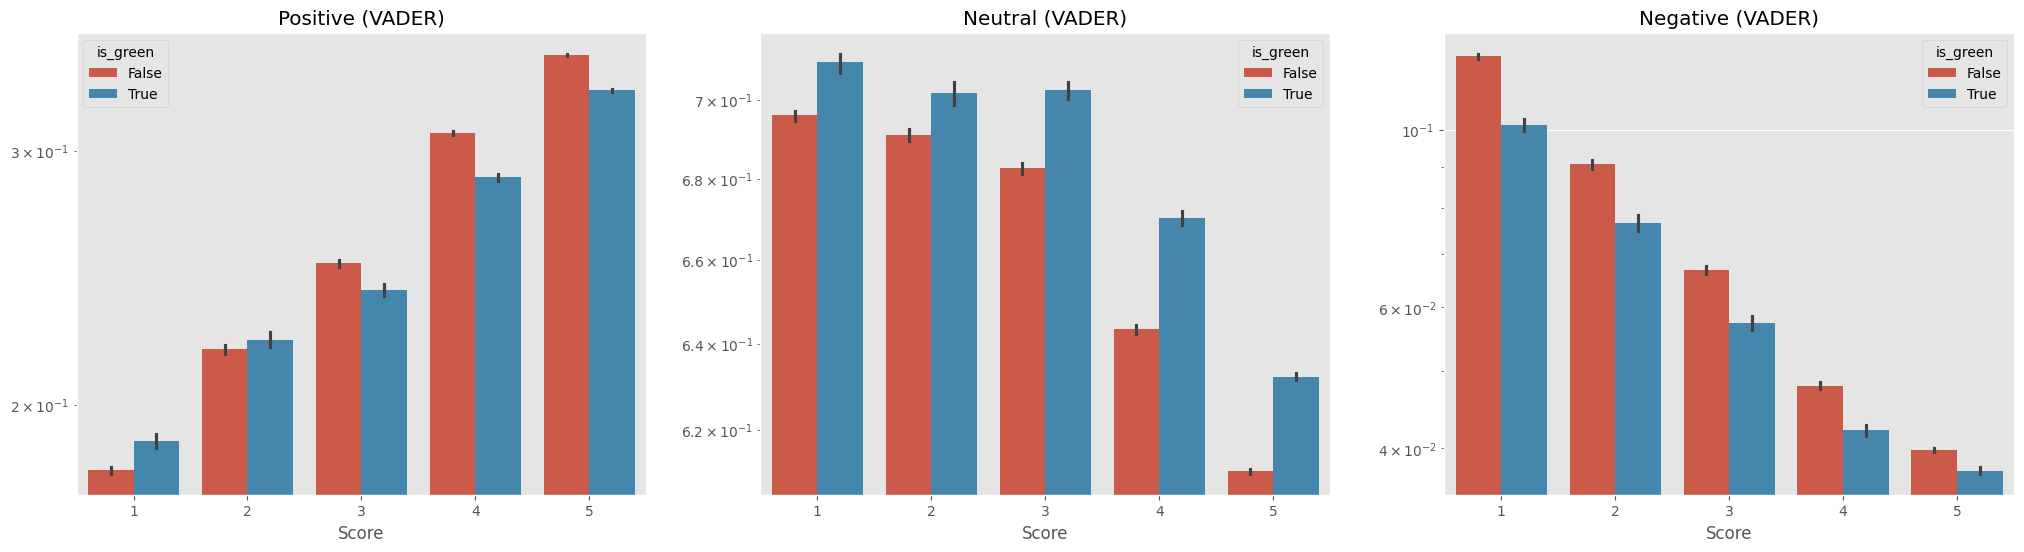

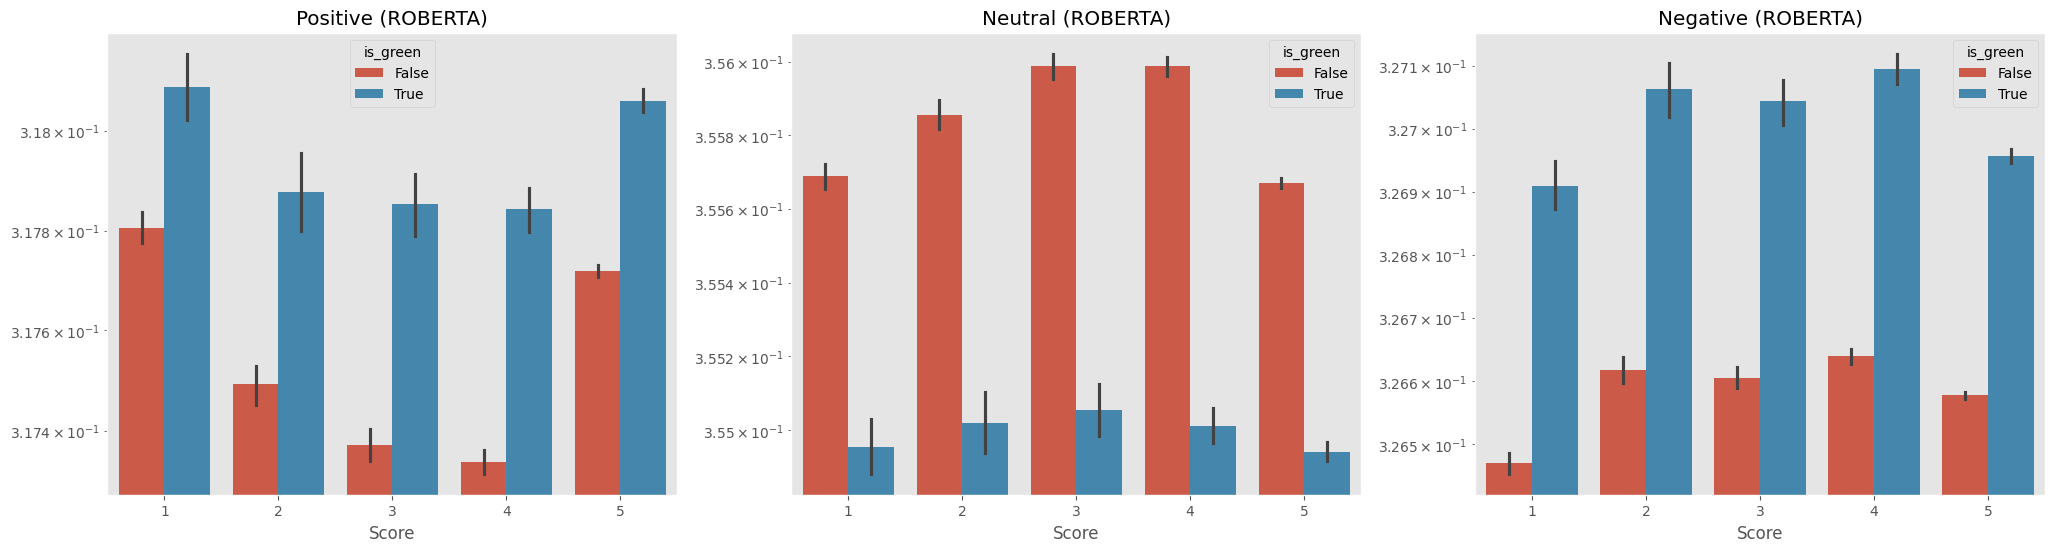

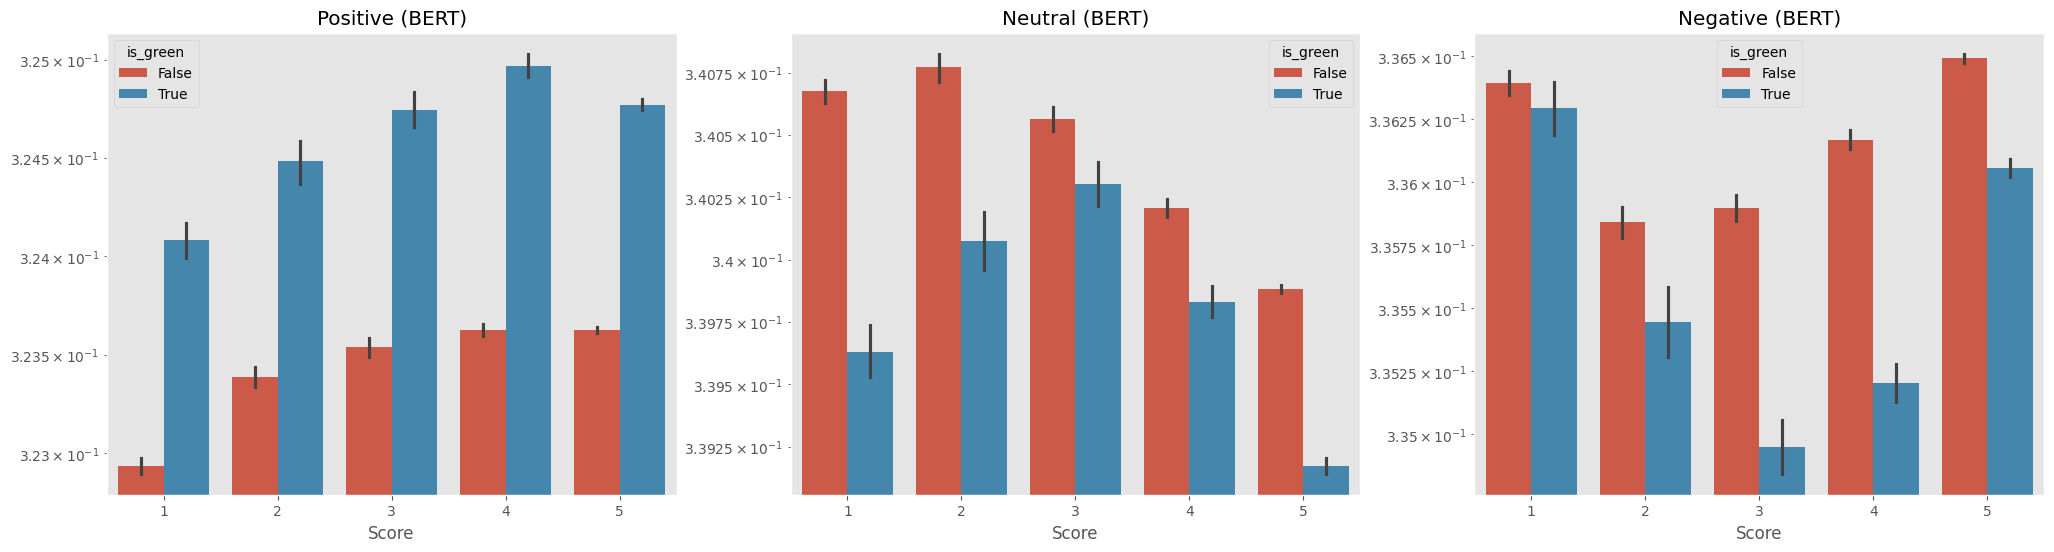

In [ ]:
# Visualization of VADER and BERT Sentiment Scores
_, axs1 = plt.subplots(1, 3, figsize=(25, 6))
_, axs2 = plt.subplots(1, 3, figsize=(25, 6))
_, axs3 = plt.subplots(1, 3, figsize=(25, 6))

# Define the fields and titles for the comparison plots
fields = [(0, 'pos', 'rob_pos', 'distil_pos', 'Positive'), (1, 'neu', 'rob_neu', 'distil_neu', 'Neutral'), (2, 'neg', 'rob_neg', 'distil_neg', 'Negative')]

# Plot for Green products
for index, vader_field, roberta_field, bert_field, title in fields:
    sns.barplot(data=df, x='Score', y=vader_field, hue='is_green', ax=axs1[index]).set(ylabel=None, yscale="log")
    axs1[index].set_title(f'{title} (VADER)')

    sns.barplot(data=df, x='Score', y=roberta_field, hue='is_green', ax=axs2[index]).set(ylabel=None, yscale="log")
    axs2[index].set_title(f'{title} (ROBERTA)')

    sns.barplot(data=df, x='Score', y=bert_field, hue='is_green', ax=axs3[index]).set(ylabel=None, yscale="log")
    axs3[index].set_title(f'{title} (BERT)')

plt.show()

# Training & Test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

# Efficient Data Preparation
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

# Selecting relevant columns
X = df['Text']
y = df['Sentiment']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),  # Use up to 3000 features to save computation
    ('clf', LogisticRegression(solver='liblinear', max_iter=50))  # Reduced max_iter for efficiency
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'tfidf__max_df': [0.7, 0.8],
    'clf__C': [0.1, 1]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Test the model
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f'Best Model Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print('Classification Report:')
print(report)

Best Model Parameters: {'clf__C': 1, 'tfidf__max_df': 0.7}
Accuracy: 89.28%
Precision: 0.91
Recall: 0.95
F1-Score: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.68      0.73     24666
           1       0.91      0.95      0.93     89025

    accuracy                           0.89    113691
   macro avg       0.86      0.81      0.83    113691
weighted avg       0.89      0.89      0.89    113691



# Evaluation

Accuracy: 88.79%
Precision: 0.91
Recall: 0.96
F1-Score: 0.93
Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.65      0.72     99674
    Positive       0.91      0.96      0.93    355090

    accuracy                           0.89    454764
   macro avg       0.85      0.80      0.82    454764
weighted avg       0.88      0.89      0.88    454764



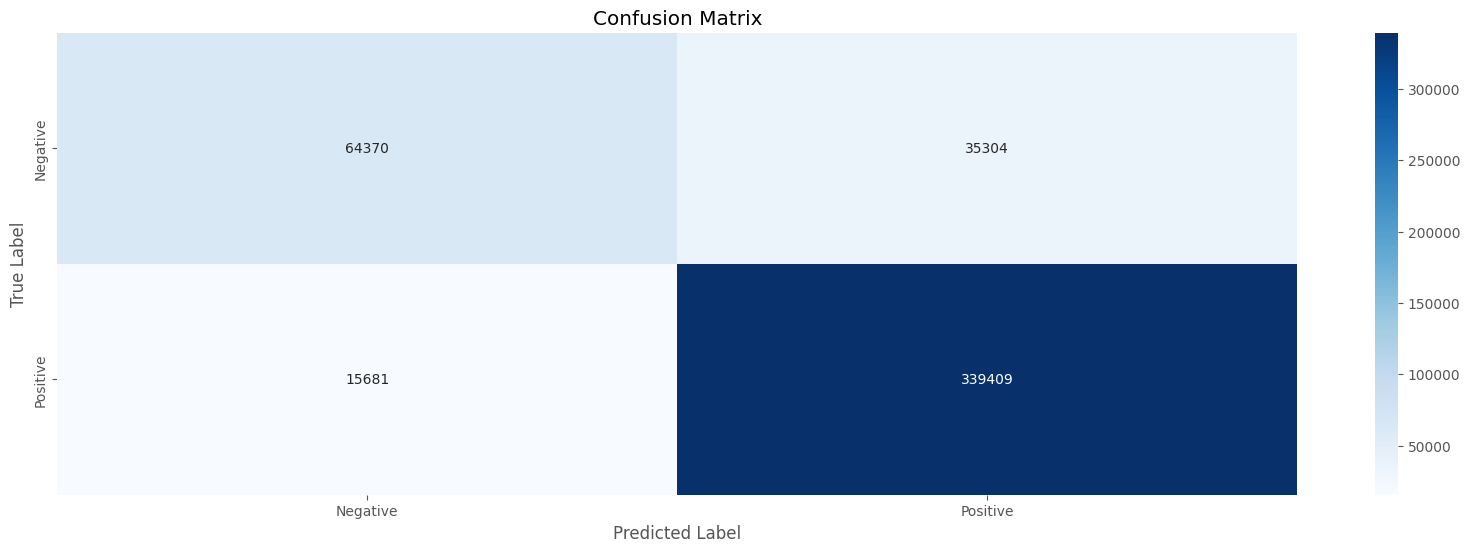

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Preprocess data
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

# Selecting relevant columns
X = df['Text']
y = df['Sentiment']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Define a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),  # Use up to 3000 features to save computation
    ('clf', LogisticRegression(solver='liblinear', max_iter=50))  # Reduced max_iter for efficiency
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'tfidf__max_df': [0.7, 0.8],
    'clf__C': [0.1, 1]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Test the model
y_pred = best_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1-Score
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.2f}')

# Generate Classification Report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print('Classification Report:')
print(report)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(20, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()